# Implementing Collaborative Filtering Using Autoencoders

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D,  MaxPooling1D, Flatten, Conv1DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

import tensorflow as tf

In [ ]:
# Reading the ratings.csv file
raw_data  = pd.read_csv('ratings.csv').drop('timestamp', axis=1)

# Ensuring that the movie ids go from zero to the maximum number of unique movies
raw_data['movieId'] = pd.factorize(raw_data['movieId'])[0]

# Ensuring that the user ids start from zero
raw_data['userId'] = raw_data['userId'] - 1

# Finding the number of unique users and the number of unique movies
# This will be used as the dimensions of the matrix that will be used for training
unique_users =len(raw_data['userId'].unique())
unique_movies = len(raw_data['movieId'].unique())

In [ ]:
raw_data.head()

,userId,movieId,rating
0,0,0,4.0
1,0,1,4.0
2,0,2,4.0
3,0,3,5.0
4,0,4,5.0


In [ ]:
# Splitting the data into training and testing dataframes
x_train, x_test = train_test_split(raw_data, stratify=raw_data['userId'], test_size=0.15, random_state=42)

In [ ]:
# Shoing an example of the training sparse matrix/table
x_train_pvt_table = x_train.pivot_table(index='userId',columns='movieId',values='rating')
x_train_pvt_table.fillna(0, inplace=True)
x_train_pvt_table.head(10)

movieId,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9676,9677,9678,9679,9680,9681,9682,9683,9684,9685,9686,9687,9688,9689,9690,9691,9692,9693,9694,9695,9696,9697,9699,9700,9701,9702,9704,9705,9707,9708,9709,9710,9711,9713,9714,9715,9719,9720,9722,9723
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,4.0,0.0,4.0,5.0,5.0,3.0,5.0,4.0,5.0,5.0,5.0,0.0,3.0,5.0,4.0,5.0,3.0,3.0,5.0,4.0,4.0,5.0,4.0,3.0,4.0,5.0,4.0,3.0,5.0,4.0,4.0,5.0,4.0,4.0,4.0,5.0,5.0,3.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,3.0,0.0,5.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,5.0,4.0,4.0,0.0,0.0,0.0,5.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,2.0,5.0,5.0,5.0,0.0,3.0,4.0,0.0,0.0,0.0,5.0,5.0,3.0,3.0,3.0,5.0,5.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.5,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,4.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,3.0,4.0,0.0,5.0,0.0,0.0,0.0,5.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# creating sparse metricies, where the rows represnts usres and the columns represents movies

## Creating the training sparse matrix
train_matrix = np.zeros((unique_users,unique_movies))
for (ind, us_id, mv_id, rat) in x_train.itertuples():
    train_matrix[us_id, mv_id] = rat

## Creating the testing sparse matrix
test_matrix = np.zeros((unique_users,unique_movies))
for (ind, us_id, mv_id, rat) in x_test.itertuples():
    test_matrix[us_id, mv_id] = rat


In [ ]:
# Defining the masked rmse loss
def mskd_rmse(y_actual, y_predicted):
        true_msk = K.cast(K.not_equal(y_actual, 0), K.floatx())
        diff = y_actual - y_predicted
        mskd_sqr_err = K.square(true_msk * diff)
        mskd_rmse = K.sqrt(K.sum(mskd_sqr_err, axis=-1) / K.maximum(K.sum(true_msk, axis=-1), 1))
        return mskd_rmse

## Building an Autoencoder

In [ ]:
# Building the Deep Autoencoder
input= Input(shape=(train_matrix.shape[1],), name = 'Input_Layer')
latent_space = Dense(units=50, activation='elu', name = 'Latent_Space')(input)
output = Dense(units=train_matrix.shape[1], activation='elu', name = 'Output_Layer')(latent_space)

model = Model(input, output, name = 'Autoencoder')

# Compiling the model
model.compile(optimizer = 'adam', loss=mskd_rmse, metrics=[mskd_rmse])

# Model Summary
model.summary()


Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 9724)]            0         
_________________________________________________________________
Latent_Space (Dense)         (None, 50)                486250    
_________________________________________________________________
Output_Layer (Dense)         (None, 9724)              495924    
Total params: 982,174
Trainable params: 982,174
Non-trainable params: 0
_________________________________________________________________


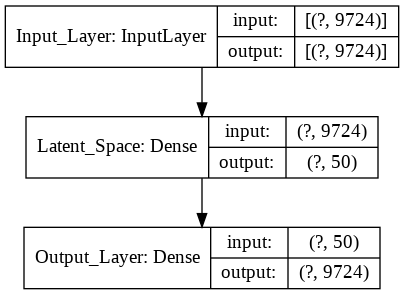

In [ ]:
tf.keras.utils.plot_model(model, to_file='AE.png', show_shapes=True)

In [ ]:
history = model.fit(train_matrix, train_matrix, epochs=50, batch_size=256, verbose = 0)

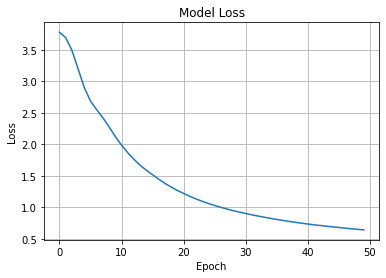

In [ ]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.show()

In [ ]:
test_loss = model.evaluate(train_matrix, test_matrix)

20/20 [==============================] - 0s 3ms/step - loss: 1.0642 - mskd_rmse: 1.0642


## Building a Deep Autoencoder

In [ ]:
# Building the Deep Autoencoder
input= Input(shape=(train_matrix.shape[1],), name = 'Input_Layer')
enc = Dense(units=64, activation='elu', name = 'Encoder_Layer_1')(input)
enc = Dense(units=32, activation='elu', name = 'Encoder_Layer_2')(enc)
enc = Dense(units=16, activation='elu', name = 'Latent_Space')(enc)
dec = Dense(units=32, activation='elu', name = 'Decoder_Layer_1')(enc)
dec = Dense(units=64, activation='elu', name = 'Decoder_Layer_2')(dec)
dec = Dense(units=train_matrix.shape[1], activation='elu', name = 'Output_Layer')(dec)

model = Model(input, dec, name = 'Deep_Autoencoder')

model.compile(optimizer = 'adam', loss=mskd_rmse, metrics=[mskd_rmse])

model.summary()


Model: "Deep_Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 9724)]            0         
_________________________________________________________________
Encoder_Layer_1 (Dense)      (None, 64)                622400    
_________________________________________________________________
Encoder_Layer_2 (Dense)      (None, 32)                2080      
_________________________________________________________________
Latent_Space (Dense)         (None, 16)                528       
_________________________________________________________________
Decoder_Layer_1 (Dense)      (None, 32)                544       
_________________________________________________________________
Decoder_Layer_2 (Dense)      (None, 64)                2112      
_________________________________________________________________
Output_Layer (Dense)         (None, 9724)         

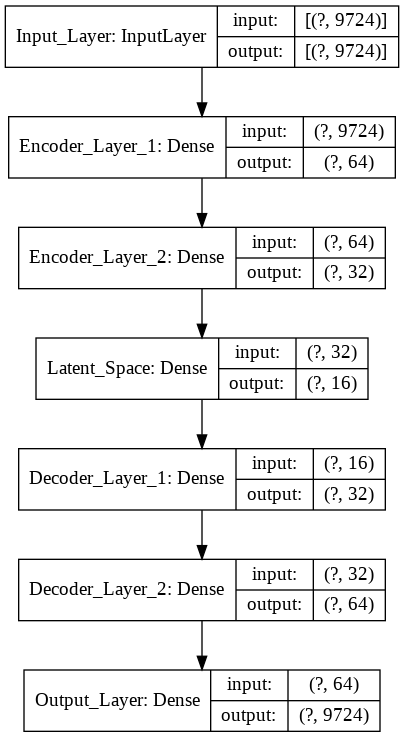

In [ ]:
tf.keras.utils.plot_model(model, to_file='DAE.png', show_shapes=True)


In [ ]:
history = model.fit(train_matrix, train_matrix, epochs=128, batch_size=256, verbose = 0)

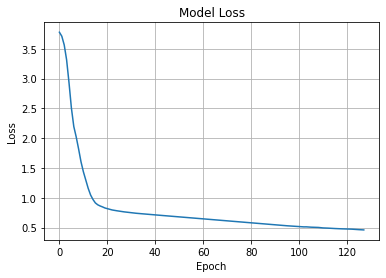

In [ ]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.show()

In [ ]:
test_loss = model.evaluate(train_matrix, test_matrix)


20/20 [==============================] - 0s 6ms/step - loss: 0.8336 - mskd_rmse: 0.8336


# Implementing collaborative filtering using SVD

In [ ]:
!pip install scikit-surprise


     |████████████████████████████████| 11.8MB 260kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670918 sha256=8da16b60528ee641f5ef97f249e757a8680f70192cfad0bafb3086e20876bbde
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
from surprise import SVD, KNNBasic, NormalPredictor, KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split

In [ ]:
# Loading the movielens dataset
data_set = Dataset.load_builtin('ml-100k')


Dataset ml-100k could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from http://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


In [ ]:
# Splitting the data int training and testing
train_data, test_data = train_test_split(data_set, test_size=0.15, random_state=42)

In [ ]:
# Using the svd matrix factorization
svd = SVD(n_factors=64, n_epochs=32, lr_all=.008)

# Training the model
history = svd.fit(train_data)

# Testing the model
results_svd = svd.test(test_data)

# Calculating the RMSE
rmse_svd = accuracy.rmse(results_svd)

#print('The RMSE of the SVD algorithm is ' + str(rmse_svd))




RMSE: 0.9583


In [ ]:
# Using the svd matrix factorization
svd = SVD(n_factors=64, n_epochs=16, lr_all=.008)

# Training the model
history = svd.fit(train_data)

# Testing the model
results_svd = svd.test(test_data)

# Calculating the RMSE
rmse_svd = accuracy.rmse(results_svd)

#print('The RMSE of the SVD algorithm is ' + str(rmse_svd))




RMSE: 0.9260


# Implementing collaborative filtering using KNN

## Basic KNN

In [ ]:
# Using the knn matrix factorization
knn = KNNBasic(k=25, min_k=1)

# Training the model
knn.fit(train_data)

# Testing the model
results_knn = knn.test(test_data)

# Calculating the RMSE
rmse_knn = accuracy.rmse(results_knn)

#print('The RMSE of the KNN algorithm is ' + str(rmse_knn))


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9709


In [ ]:
# Using the knn matrix factorization
knn = KNNBasic(k=25, min_k=1)

# Training the model
knn.fit(train_data)

# Testing the model
results_knn = knn.test(test_data)

# Calculating the RMSE
rmse_knn = accuracy.rmse(results_knn)

#print('The RMSE of the KNN algorithm is ' + str(rmse_knn))


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9709


## KNN with mean

In [ ]:
# Using the knn matrix factorization
knn_mean = KNNWithMeans(k=25, min_k=1)

# Training the model
knn_mean.fit(train_data)

# Testing the model
results_knn_mean = knn_mean.test(test_data)

# Calculating the RMSE
rmse_knn_mean = accuracy.rmse(results_knn_mean)

#print('The RMSE of the KNN algorithm is ' + str(rmse_knn))


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9509


# Using random recommendations

In [ ]:
# Using the knn matrix factorization
rand = NormalPredictor()

# Training the model
rand.fit(train_data)

# Testing the model
results_rand = rand.test(test_data)

# Calculating the RMSE
rmse_rand = accuracy.rmse(results_rand)

#print('The RMSE of the rand algorithm is ' + str(rmse_rand))


RMSE: 1.5211


# References
1. https://github.com/RaptorMai/Deep-AutoEncoder-Recommendation
2. https://surprise.readthedocs.io/en/stable/getting_started.html